In [1]:
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import constants for the days of the week
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import seaborn as sns;

# tick on mondays every week

# tick on mondays and saturdays
# %matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

def cleanPriceData_df(ret_df):
    ret_df = ret_df.iloc[:, :-1]
    ret_df = ret_df.transpose()
    ticnames = ret_df.iloc[0, :]
    ret_df = ret_df.iloc[1:, :]
    dates = ret_df.index.str.split().str.get(-1)
    dates = pd.to_datetime(dates,format='%d/%m/%y')
    ret_df = ret_df.set_index(dates)
    ret_df.columns = ticnames
    ret_df = ret_df.fillna(0)
    ret_df=ret_df/100
    ret_df.sort_index(inplace=True)
    return ret_df


# Read CSVs
compinfo=  pd.read_csv('C:\Python\FtseCluster\data\Filtered_FTSE All-share_CompanyInfo_nonInv.csv')
compinfo = compinfo.set_index('TIDM')
ft_idx  =  pd.read_csv('C:\Python\FtseCluster\data\FTASX.csv',parse_dates=['Date'], index_col='Date')
ft_idx=ft_idx.sort_index()
cov_timeline=pd.read_csv('C:\Python\FtseCluster\data\COVID_Timeline.csv',parse_dates=['Date'], index_col='Date')
ft_idx=ft_idx.sort_index()

tdf1= pd.read_csv('C:\Python\FtseCluster\data\Filtered_FTSE All-share_Daily_11Mar_to_23April.csv')
tdf1  =  cleanPriceData_df(tdf1)
tdf2= pd.read_csv('C:\Python\FtseCluster\data\Filtered_FTSE All-share_Daily_01Feb_to_11Mar.csv')
tdf2  =  cleanPriceData_df(tdf2)
bus_description = pd.read_csv('C:\Python\FtseCluster\data\FtseAllShareDetails_HL.csv',usecols=['EPIC','Bussinfo'],index_col=['EPIC'])



dly_ret=tdf1.append(tdf2)
dly_ret = dly_ret.sort_index(ascending= True)
dly_ret = dly_ret.loc['10 Feb 2020' : '23 Mar 2020']
index_ret=ft_idx[['DailyRet']]['10 Feb 2020' : '23 Mar 2020']
index_ret = index_ret.rename(columns={"DailyRet": "FTSE All Share Index"})

cov_timeline=cov_timeline.sort_index()
SectorList = compinfo['Sector'].unique()
SupSectorList = compinfo['Supersector'].unique()
SubSectorList = compinfo['Subsector'].unique()
IndustryList = compinfo['Industry'].unique()

SubSec_tics={}
for sec in SubSectorList:
    SubSec_tics[sec]=compinfo[compinfo.Subsector==sec].index.values


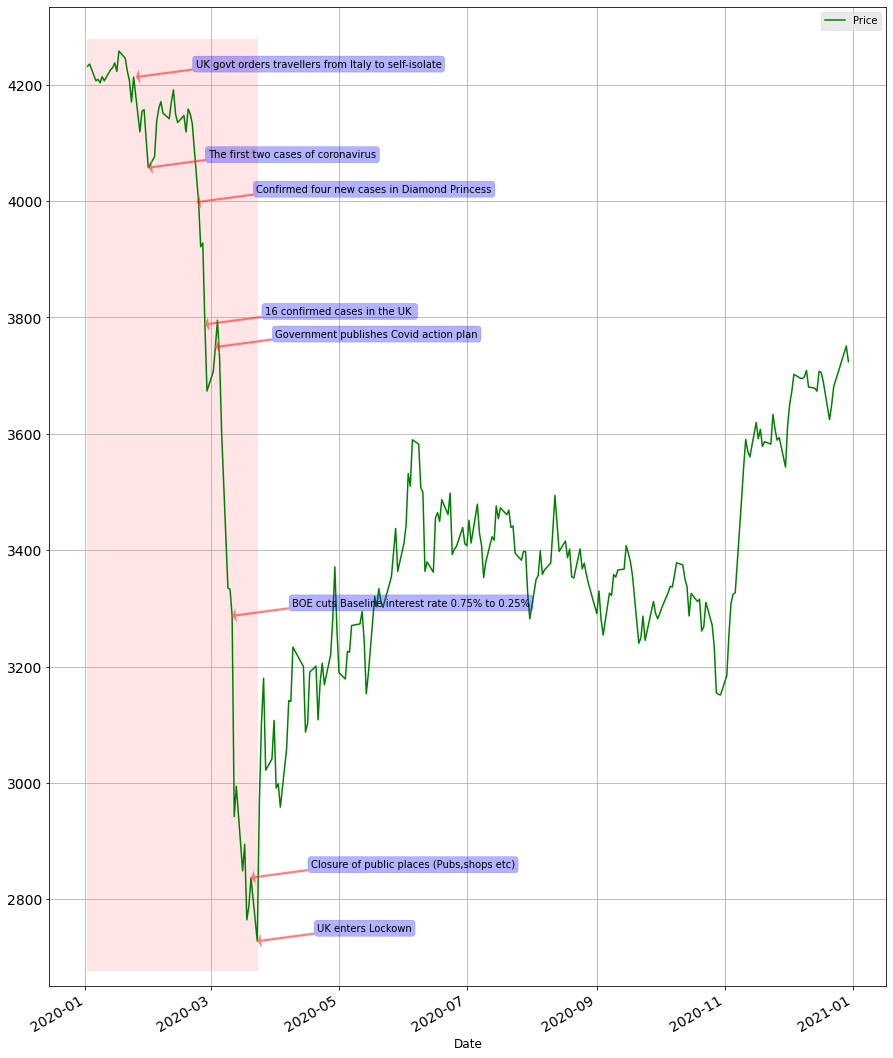

In [2]:
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(1, 1, 1)

plt.style.use('ggplot')
df=ft_idx[['Price']].loc['1 Jan 2020' : '30 dec 2020']
df.plot(ax=ax,color='g')

for date,label in cov_timeline.iterrows(): 
    val=df.iloc[df.index.get_loc(date, method='nearest')]
    xpos=date+pd.DateOffset(days=0)
    tpos=date+pd.DateOffset(days=15)
    ax.annotate(label.values[0],
            xy=(xpos,val), xycoords='data',
            xytext=(60,10), textcoords='offset points',bbox=dict(boxstyle="round",color='b', alpha=0.3),
               arrowprops=dict(facecolor='red', headwidth=15, width=2.5, headlength=4,alpha=0.5) )
x=mdates.date2num(df.index[0])
y=df.min().values[0]-50
end=mdates.date2num(cov_timeline.index[-1])
width=end-x
rect = plt.Rectangle((x,y),width,1600, color='r', alpha=0.1)
ax.add_patch(rect)
# #
# https://charliepownall.com/uk-government-covid19-response-timeline/
# https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_England_(2020)




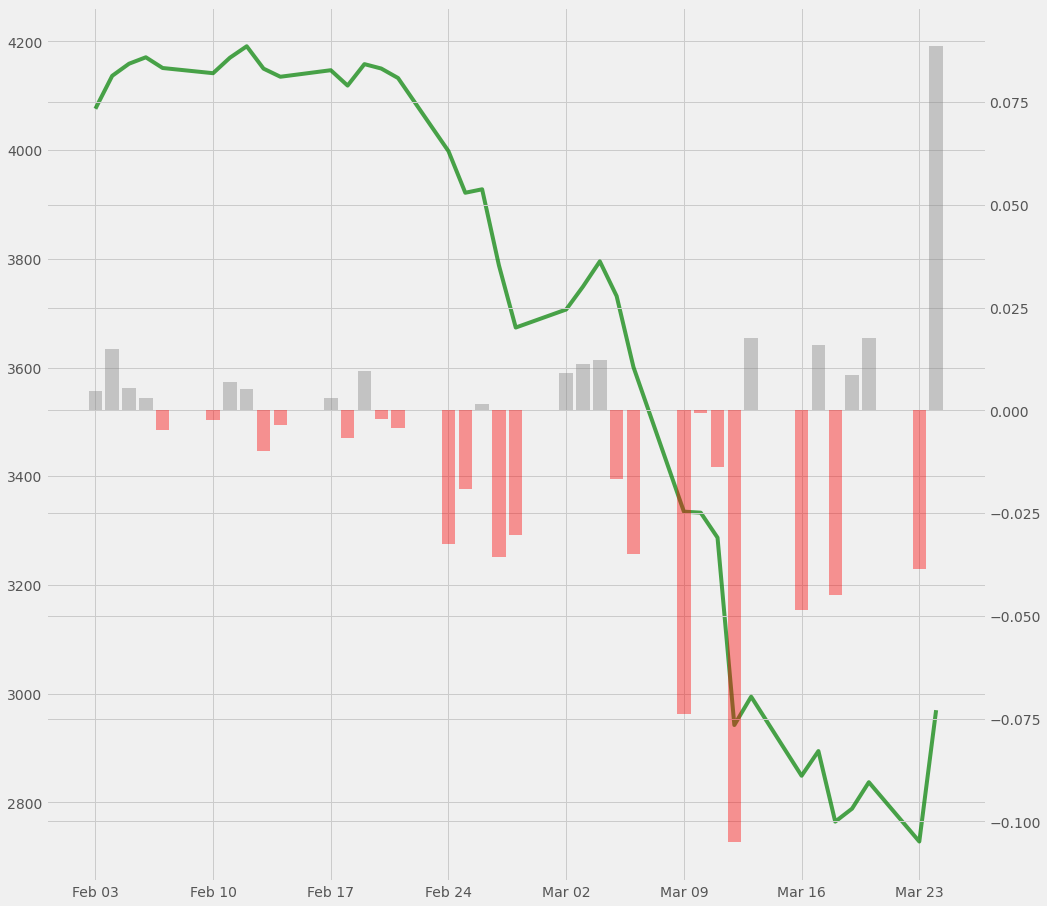

In [3]:
def barcol(val):
    if val < 0 :
        return 'r'
    else:
        return 'grey'

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, 1,figsize=(15,15))

t_window=ft_idx['DailyRet'].loc['01 Feb 2020' : '24 Mar 2020'].index
x1=ft_idx['Price'].loc[t_window]
x2=ft_idx['DailyRet'].loc[t_window]
ax1.plot(t_window, x1,color='g',alpha=0.7)
ax2 = ax1.twinx()
col = x2.apply(lambda x:barcol(x))
ax2.bar(t_window, x2,color=col,alpha=0.4)
ax2.xaxis_date()
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()





In [5]:
def SecGroupRet(ICB_classification):
    secs = compinfo[ICB_classification].unique()
    ret_df=pd.DataFrame([],index=dly_ret.index)
    for  item in secs:
        tics = compinfo[compinfo[ICB_classification] == item].index.values
        no_of_tics=tics.shape[0]
        temp=dly_ret[tics].sum(axis=1)/no_of_tics
        ret_df = ret_df.join(pd.DataFrame(temp,columns=[item]))
    return ret_df



Industry_ret = SecGroupRet('Industry')
Supsec_ret = SecGroupRet('Supersector')
Sector_ret = SecGroupRet('Sector')
Subsec_ret = SecGroupRet('Subsector')

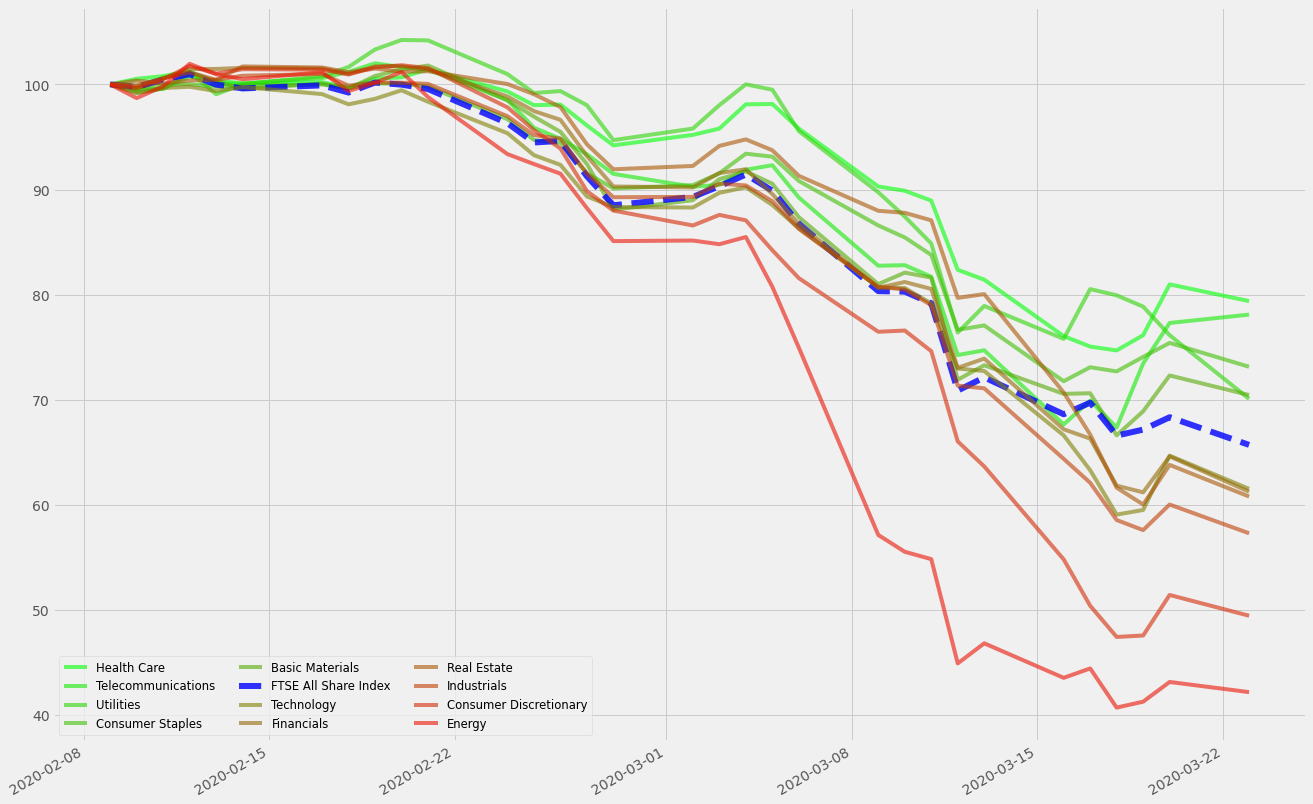

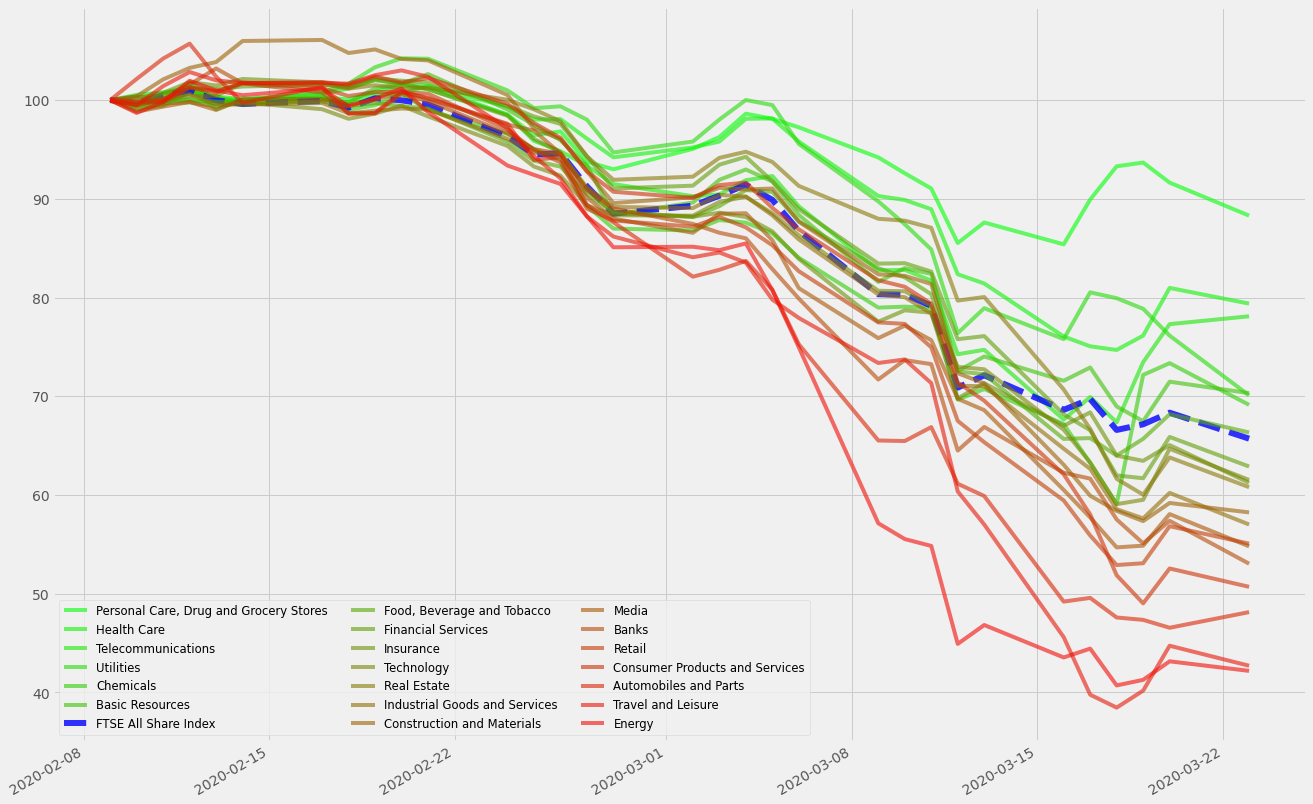

In [6]:
def CalcportValue(rt_df):
    PortVal = pd.DataFrame(100,index=[pd.to_datetime('9 Feb 2020')],columns=rt_df.columns)
    PortVal = PortVal.append(rt_df+1)
    PortVal = PortVal.cumprod()
    return PortVal

plt.style.use('fivethirtyeight')
IndexPort=CalcportValue(index_ret)
IndustryPort =CalcportValue(Industry_ret)
SupSectorPort =CalcportValue(Supsec_ret)
SectorPort =CalcportValue(Sector_ret)
SubSectorPort =CalcportValue(Subsec_ret)

IndustryPort = IndustryPort.join(IndexPort.copy())
fig, (ax1) = plt.subplots(1, 1,figsize=(20,15))
PortVal_19Mar = IndustryPort.loc['20 Mar 2020'].sort_values(ascending=False)
sorted_cols=PortVal_19Mar.index.values
for i,col in enumerate(sorted_cols):
    if(col=="FTSE All Share Index"):
        IndustryPort[col].plot(ax=ax1,style= 'b--',linewidth=6.0,alpha=0.8)
    else:
        IndustryPort[col].plot(ax=ax1, color = ( i /len(sorted_cols) ,1-(i /len(sorted_cols)), .02),alpha=0.6)

ax1.legend(loc='lower left',fontsize ='small',fancybox=True, ncol=3)
plt.show()

SupSectorPort = SupSectorPort.join(IndexPort.copy())
fig, (ax1) = plt.subplots(1, 1,figsize=(20,15))
PortVal_19Mar = SupSectorPort.loc['20 Mar 2020'].sort_values(ascending=False)
sorted_cols=PortVal_19Mar.index.values
for i,col in enumerate(sorted_cols):
    if(col=="FTSE All Share Index"):
        SupSectorPort[col].plot(ax=ax1,style= 'b--',linewidth=6.0,alpha=0.8)
    else:
        SupSectorPort[col].plot(ax=ax1, color = ( i /len(sorted_cols) ,1-(i /len(sorted_cols)), .02),alpha=0.6)

ax1.legend(loc='lower left',fontsize ='small',fancybox=True, ncol=3)
plt.show()

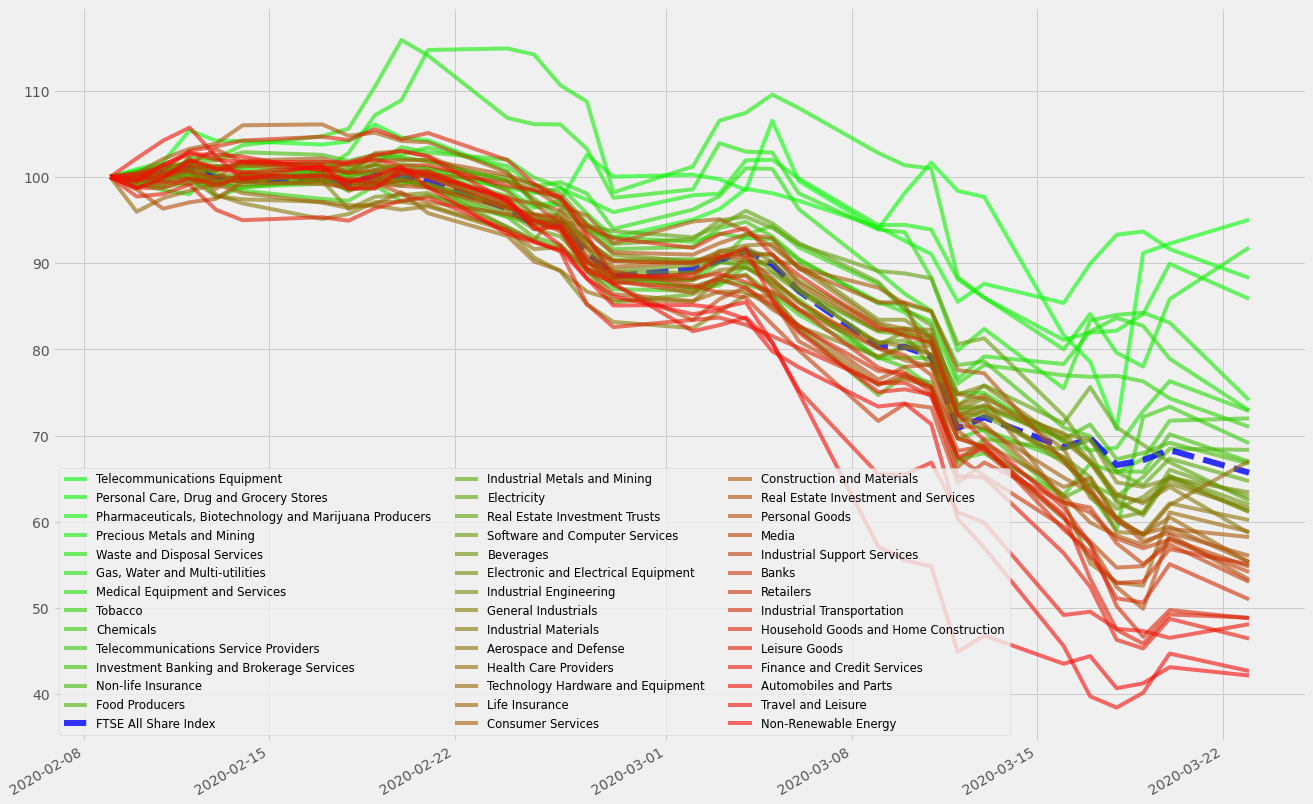

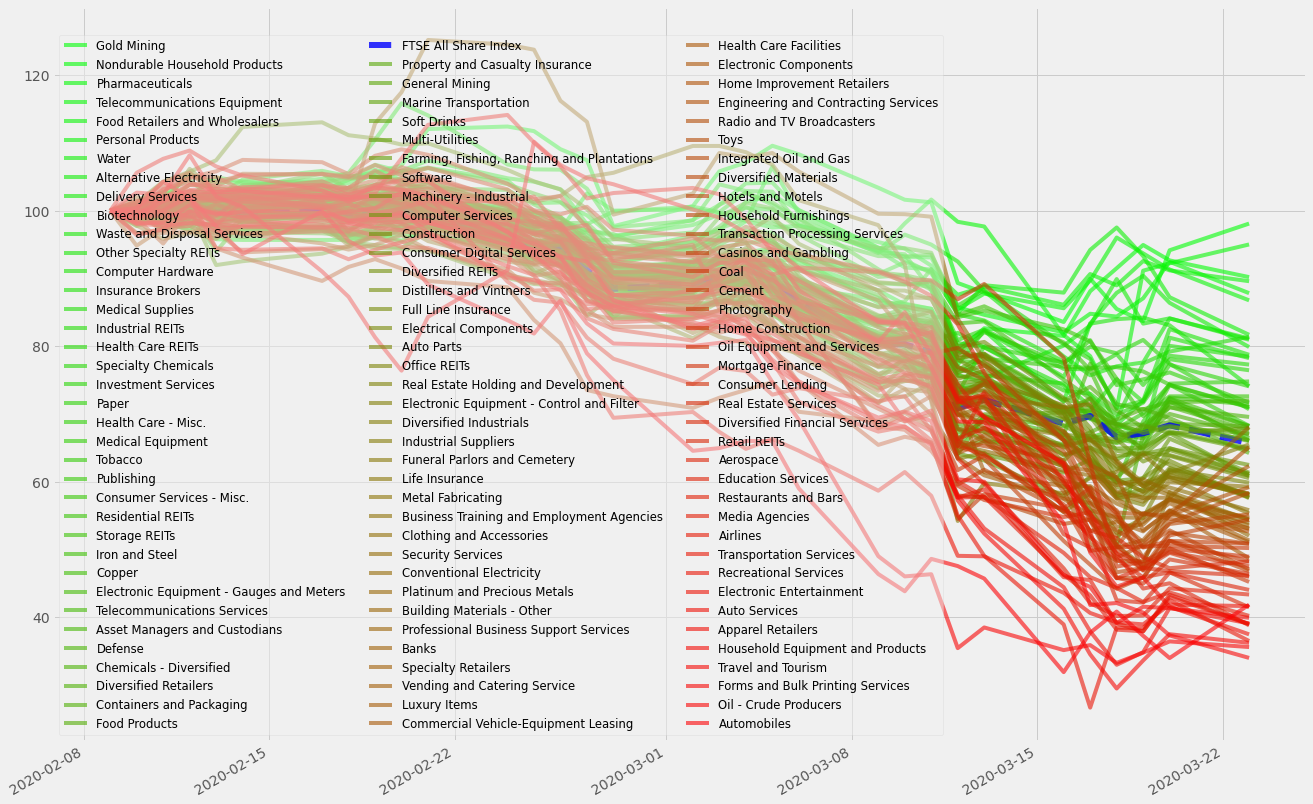

In [7]:
SectorPort = SectorPort.join(IndexPort.copy())
fig, (ax1) = plt.subplots(1, 1,figsize=(20,15))
PortVal_19Mar = SectorPort.loc['20 Mar 2020'].sort_values(ascending=False)
sorted_cols=PortVal_19Mar.index.values
for i,col in enumerate(sorted_cols):
    if(col=="FTSE All Share Index"):
        SectorPort[col].plot(ax=ax1,style= 'b--',linewidth=6.0,alpha=0.8)
    else:
        SectorPort[col].plot(ax=ax1, color = ( i /len(sorted_cols) ,1-(i /len(sorted_cols)), .02),alpha=0.6)

ax1.legend(loc='lower left',fontsize ='small',fancybox=True, ncol=3)
plt.show()


SubSectorPort = SubSectorPort.join(IndexPort.copy())
fig, (ax1) = plt.subplots(1, 1,figsize=(20,15))
PortVal_19Mar = SubSectorPort.loc['20 Mar 2020'].sort_values(ascending=False)
sorted_cols=PortVal_19Mar.index.values
for i,col in enumerate(sorted_cols):
    if(col=="FTSE All Share Index"):
        SubSectorPort[col].plot(ax=ax1,style= 'b--',linewidth=6.0,alpha=0.8)
    else:
        SubSectorPort[col].plot(ax=ax1, color = ( i /len(sorted_cols) ,1-(i /len(sorted_cols)), .02),alpha=0.6)

ax1.legend(loc='lower left',fontsize ='small',fancybox=True, ncol=3,framealpha =0.5)
plt.show()

# Sector Analyis
- How many clusters are there on lowest point of crash ?
- How homogenous are the lower performing sectors

### Taking performers from classes by sorting and showing lowest quartile

# Choosing Classification
## we select sub sector classification which has more than 4 stocks,
## Clustering of tics between 17 feb and 23 March


In [8]:
SubSectorList_filt=[]
for sec in SubSectorList:
    no_of_tics = len(compinfo[compinfo.Subsector== sec].index)
    if  no_of_tics>= 4:
        SubSectorList_filt.append(sec)
SubSectorList_filt = list(set(SubSectorList_filt) - set(['Asset Managers and Custodians','Office REITs','Retail REITs', 'Diversified REITs', 'Health Care REITs','Real Estate Holding and Development', 'Residential REITs', 'Retail REITs']))

len(SubSectorList_filt)


38

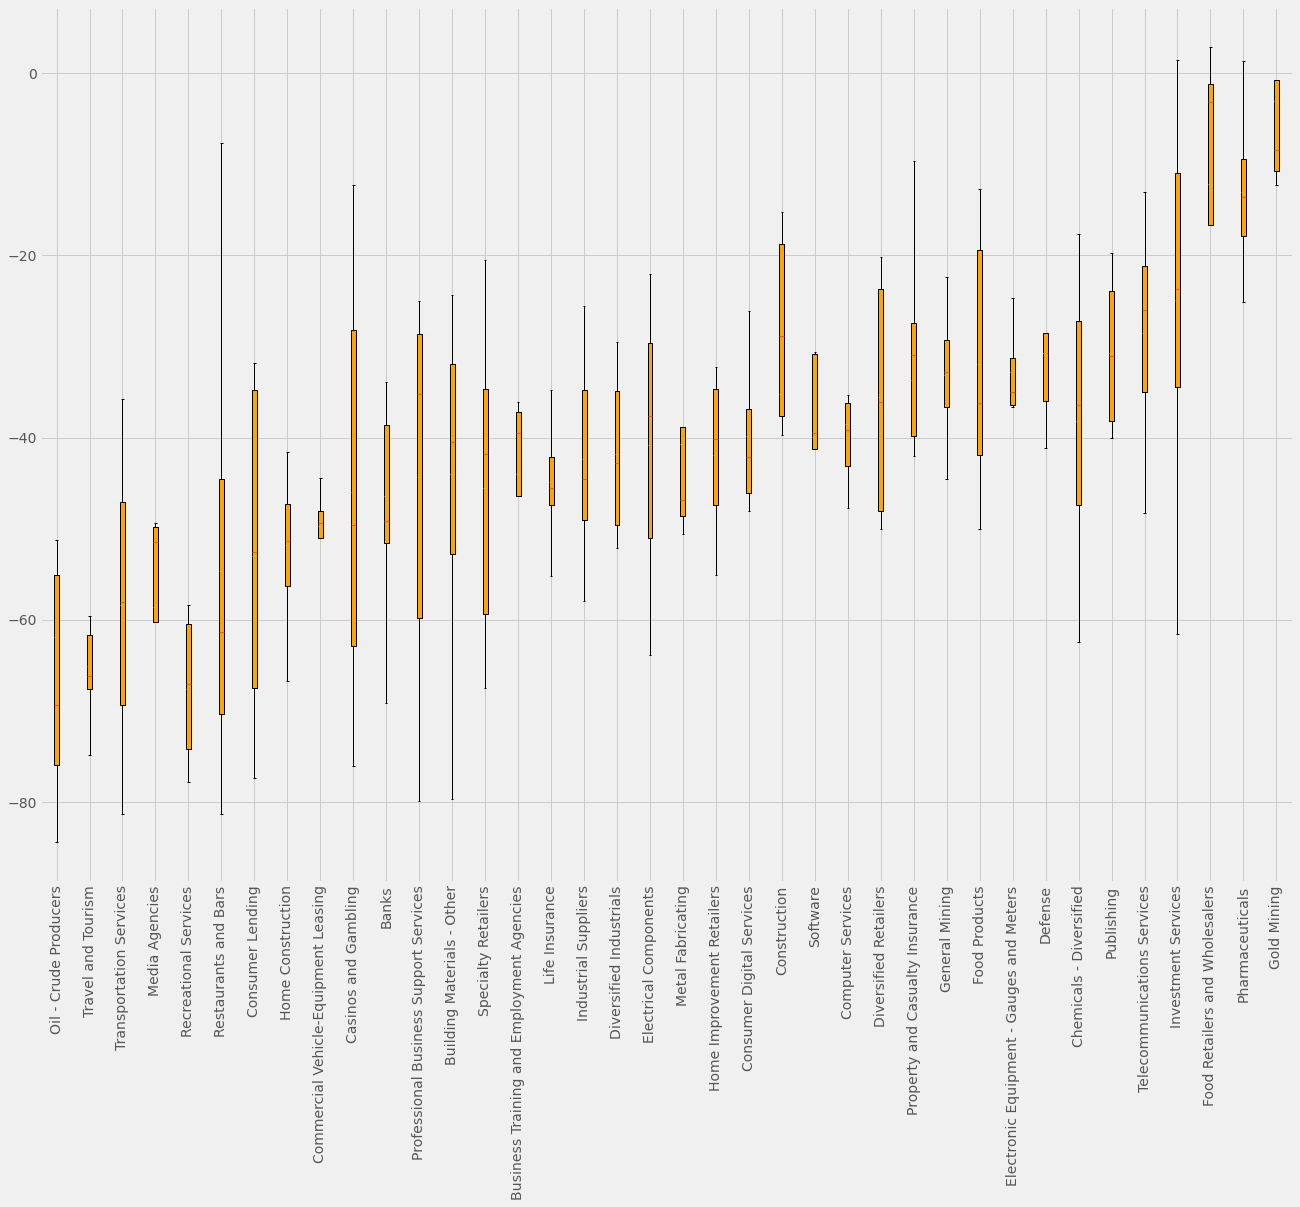

In [9]:

SubSectorList_filt= Subsec_ret[SubSectorList_filt].describe().transpose().sort_values(by='mean',ascending=True).index.values
start = '10 Feb 2020'
end = '25 mAR 2020'
filt_dailtRet=dly_ret.loc[start:end]
#Getting Period return from dailt return
port_ret = CalcportValue(filt_dailtRet)
rets=(port_ret.iloc[-1]).round(1)-100
fig, (ax1) = plt.subplots(1, 1,figsize=(20,15))
plt.style.use('fivethirtyeight')

for idx,sec in enumerate(SubSectorList_filt):
    tics = compinfo[compinfo.Subsector == sec].index
    ax1.boxplot(rets[tics].values,positions =[idx+1],showfliers =False,patch_artist=True,labels =[''], boxprops=dict(facecolor='orange'),meanline=True,
                   showmeans=True)
temp = ax1.set_xticklabels(SubSectorList_filt,rotation='vertical')

In [10]:
#Ranking Stocks in Travel and Leisure
TicRanks=pd.DataFrame(columns=['rank'])

for sec in SubSectorList_filt:
    tics = compinfo[compinfo.Subsector == sec].index
    temp =CalcportValue(filt_dailtRet[tics])
    sec_perf = temp[tics].describe().T.sort_values(['min','std'],ascending=[False,True])
    # sec_perf  =temp.drop(columns = ['count','mean','50%','75%','25%','max'])
    sec_perf=sec_perf.rename(columns={'std':'Vol','min':'drawdown'})
    no_of_tics=sec_perf.shape[0]
    sec_perf['rank']= range(1,no_of_tics+1)
    sec_perf['rank']=pd.qcut(sec_perf['rank'],q = 4, labels = False)+1
    TicRanks = TicRanks.append(sec_perf[['rank']])

In [11]:
TicRanks['mean'] = filt_dailtRet.mean()
TicRanks['Subsector'] = compinfo.loc[TicRanks.index].Subsector

In [12]:
mean_Grps = TicRanks['mean'].groupby([TicRanks['rank'],TicRanks['Subsector']]).mean()
Rankgrp_means = (mean_Grps.unstack())

[Text(0.5, 0, ''),
 Text(1.5, 0, ''),
 Text(2.5, 0, ''),
 Text(3.5, 0, ''),
 Text(4.5, 0, ''),
 Text(5.5, 0, ''),
 Text(6.5, 0, ''),
 Text(7.5, 0, ''),
 Text(8.5, 0, ''),
 Text(9.5, 0, ''),
 Text(10.5, 0, ''),
 Text(11.5, 0, ''),
 Text(12.5, 0, ''),
 Text(13.5, 0, ''),
 Text(14.5, 0, ''),
 Text(15.5, 0, ''),
 Text(16.5, 0, ''),
 Text(17.5, 0, ''),
 Text(18.5, 0, ''),
 Text(19.5, 0, ''),
 Text(20.5, 0, ''),
 Text(21.5, 0, ''),
 Text(22.5, 0, ''),
 Text(23.5, 0, ''),
 Text(24.5, 0, ''),
 Text(25.5, 0, ''),
 Text(26.5, 0, ''),
 Text(27.5, 0, ''),
 Text(28.5, 0, ''),
 Text(29.5, 0, ''),
 Text(30.5, 0, ''),
 Text(31.5, 0, ''),
 Text(32.5, 0, ''),
 Text(33.5, 0, ''),
 Text(34.5, 0, ''),
 Text(35.5, 0, ''),
 Text(36.5, 0, ''),
 Text(37.5, 0, '')]

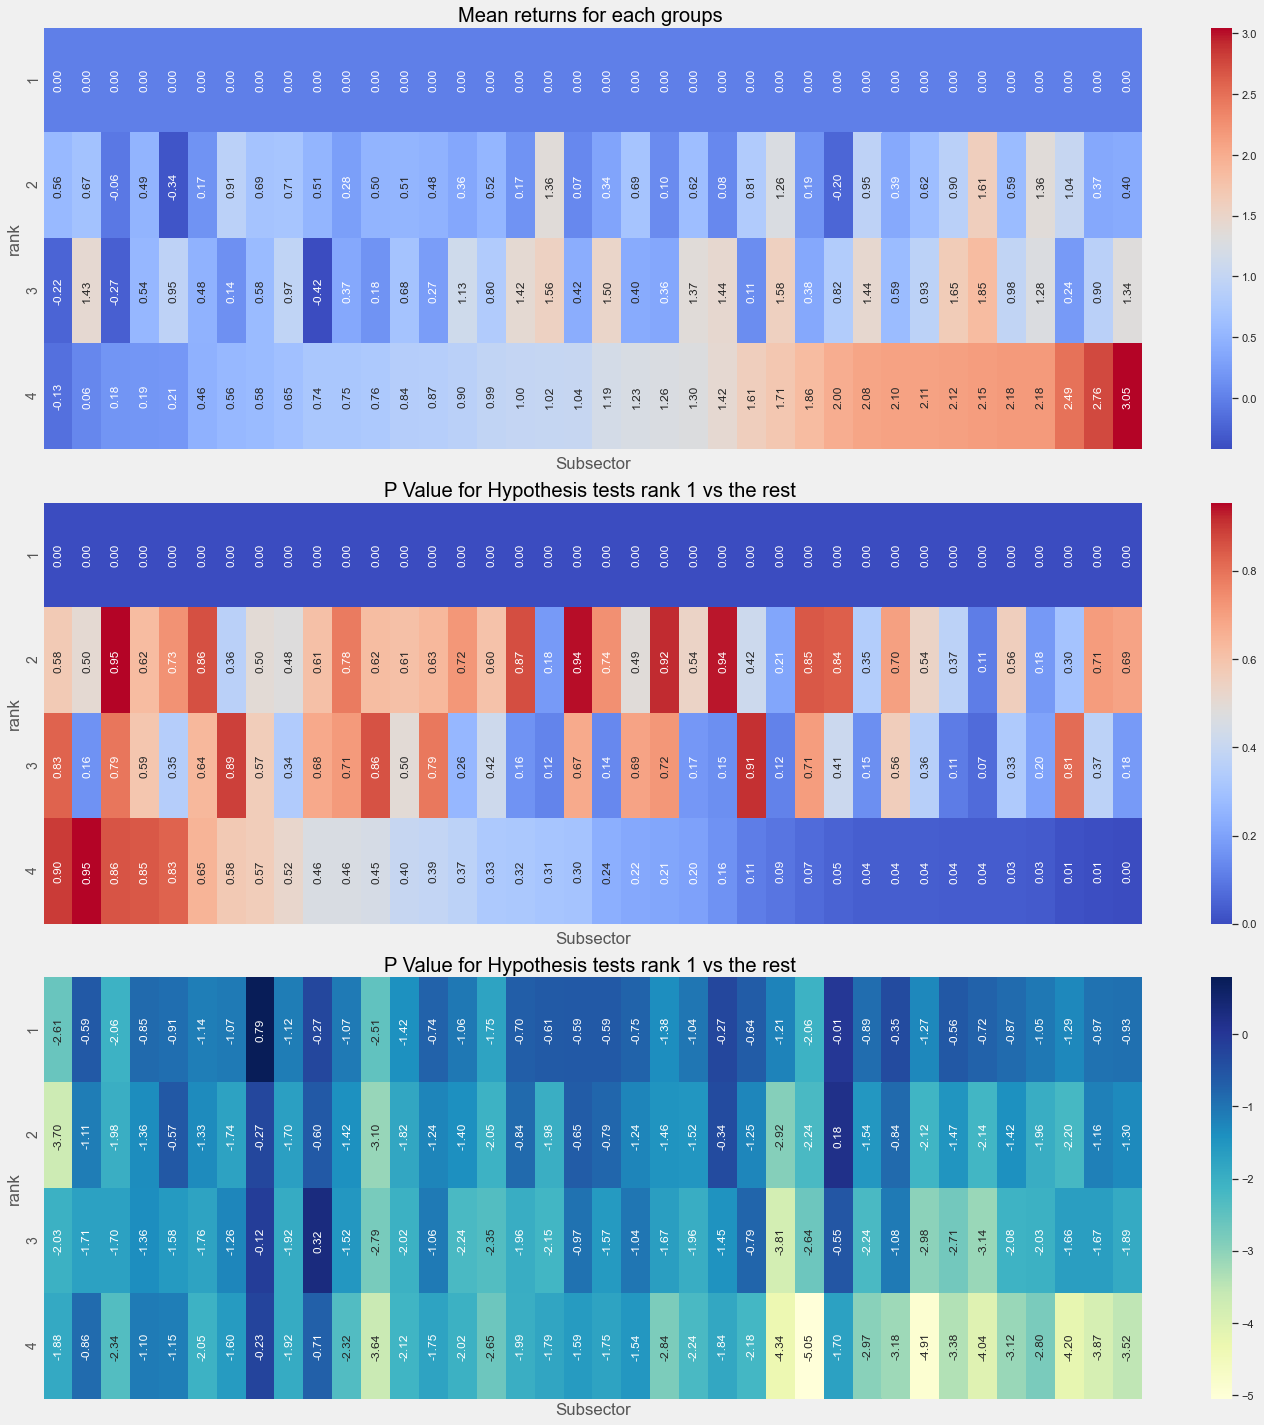

In [13]:
Rankgrp_pVals=Rankgrp_means.copy()
Rankgrp_tsat=Rankgrp_means.copy()

Rankgrp_pVals.iloc[0]=0
Rankgrp_tsat.iloc[0]=0

rank_combinations = [[1,2],[1,3],[1,4]]
for sec in SubSectorList_filt:
    for rnk in rank_combinations:
        rank_1=rnk[0]
        rank_target=rnk[1]

        rank_mask=TicRanks['rank'] == rank_1
        subsect_mask = TicRanks['Subsector'] == sec
        TicRanks[rank_mask & subsect_mask]
        s1_tics=TicRanks[rank_mask & subsect_mask].index

        rank_mask=TicRanks['rank'] == rank_target
        subsect_mask = TicRanks['Subsector'] == sec
        s2_tics=TicRanks[rank_mask & subsect_mask].index

        s1_ret=filt_dailtRet[s1_tics].unstack().values
        s2_ret=filt_dailtRet[s2_tics].unstack().values
        tstat,pval = ttest_ind(s1_ret,s2_ret,equal_var=False)
        # print('%s - Rank %d vs %d || [S%dmean - %1.2f s%dmean - %1.2f] | Tstat %2.2f Pval %2.2f'%(sec,rnk[0],rnk[1],rnk[0],
        Rankgrp_pVals.loc[rank_target][sec]  = pval                                                              #s1_ret.mean(),rnk[1],s2_ret.mean(),tstat,pval))
        Rankgrp_tsat.loc[rank_target][sec]  = tstat                                                              #s1_ret.mean(),rnk[1],s2_ret.mean(),tstat,pval))

Sec_orderby_tstat_list=Rankgrp_tsat.loc[4].sort_values().index
Rankgrp_tsat = Rankgrp_tsat[Sec_orderby_tstat_list]
Rankgrp_pVals = Rankgrp_pVals[Sec_orderby_tstat_list]
Rankgrp_means = Rankgrp_means[Sec_orderby_tstat_list]

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3, 1, 1)
ax1.set_title('Mean returns for each groups ')
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_title('P Value for Hypothesis tests rank 1 vs the rest ')
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_title('P Value for Hypothesis tests rank 1 vs the rest ')
plt.tight_layout()

sns.set_theme()
sns.heatmap(Rankgrp_means*100,cmap="YlGnBu",ax=ax3,annot=True,fmt='.2f',annot_kws={'rotation': 90},xticklabels=False)
sns.heatmap(Rankgrp_pVals, ax=ax2,cmap="coolwarm",annot=True,fmt='.2f',annot_kws={'rotation': 90})
sns.heatmap(Rankgrp_tsat, ax=ax1,annot=True,cmap="coolwarm",fmt='.2f',annot_kws={'rotation': 90})
ax1.set_xticklabels([])
ax2.set_xticklabels([])
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.1, top=0.1, wspace=None, hspace=None)


In [15]:
import textacy
import textacy.ke
corpus=[]
from textacy import preprocessing
doc = textacy.make_spacy_doc(text)
doc._.preview

NameError: name 'text' is not defined

In [ ]:
list(textacy.extract.ngrams(doc, 2, filter_stops=True, filter_punct=True, filter_nums=True))
textacy.ke.textrank(doc, normalize="lemma", topn=10)


In [ ]:
ts = textacy.TextStats(doc)
ts.n_words, ts.n_syllables, ts.n_chars


In [ ]:
bot = doc._.to_bag_of_terms(ngrams=( 2, 3,4), entities=True, weighting="count", as_strings=True)

In [ ]:
corpus = textacy.Corpus(textacy.load_spacy_lang("en_core_web_sm", disable=("parser", "tagger")),data=text)

In [ ]:
corpus[0]._.preview

In [ ]:
corpus.n_docs, corpus.n_sents, corpus.n_tokens

In [ ]:
text

In [ ]:
# import textacy.vsm # note the import
# vectorizer = textacy.vsm.Vectorizer(tf_type="linear", apply_idf=True, idf_type="smooth", norm="l2", min_df=0.1, max_df=1)
# doc_term_matrix = vectorizer.fit_transform((doc._.to_terms_list(ngrams=1, entities=True, as_strings=True) for doc in corpus))
# print(repr(doc_term_matrix))

In [ ]:
import textacy.tm
model = textacy.tm.TopicModel("nmf", n_topics=10)
# model.fit(doc_term_matrix)
# doc_topic_matrix = model.transform(doc_term_matrix)
# for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
#     print("topic", topic_idx, ":", "-".join(top_terms))

In [ ]:
# import nltk
# nltk.download()

In [ ]:
# en = textacy.load_spacy_lang("en_core_web_sm")
# doc = textacy.make_spacy_doc(text, lang=en)
# textacy.ke.textrank(doc)

In [ ]:
# print("SGRank output: ", [kps for kps, weights in textacy.ke.sgrank(doc)])
# key = textacy.ketextacy KE.sgrank(doc, ngrams=(1, 2, 3, 4, 5, 6), normalize='lemma', window_width=1500, n_keyterms=10, idf=None)

In [ ]:
#To address the issue of overlapping key phrases, textacy has a function: aggregage_term_variants.
#Choosing one of the grouped terms per item will give us a list of non-overlapping key phrases!
# terms = set([term for term,weight in textacy.ke.sgrank(doc,topn=10)])
# print(textacy.ke.utils.aggregate_term_variants(terms))

In [ ]:
# import spacy
# import pytextrank
#
# nlp = spacy.load('en_core_web_sm')
#
# tr = pytextrank.TextRank()
# nlp.add_pipe(tr.PipelineComponent, name='textrank', last=True)
#
#
# # examine the top-ranked phrases in the document
# for p in doc._.phrases:
#     print('{:.4f} {:5d}  {}'.format(p.rank, p.count, p.text))
#     print(p.chunks)

In [ ]:

# import spacy
# import neuralcoref
#
# nlp = spacy.load('en')
# neuralcoref.add_to_pipe(nlp)
# print(doc._.coref_clusters)
#
# doc2 = nlp('Angela lives in Boston. She is quite happy in that city.')
# for ent in doc2.ents:
#     print(ent._.coref_cluster)

In [ ]:
import textacy
import spacy
# import neuralcoref
#

SubSector_text={}
for sec in Sec_orderby_tstat_list:
    tics = SubSec_tics[sec]
    SubSector_text[sec] = ' '.join(bus_description.loc[tics].Bussinfo)



nlp = spacy.load('en')
doc = nlp(text)

for entity in doc.ents:
    print(f"{entity.text} ({entity.label_})")

In [ ]:
def redact_names(text):
    doc = nlp(text)
    redacted_sentence = []
    for ent in doc.ents:
        ent.merge()
    for token in doc:
        if token.ent_type_ == "PERSON" or token.ent_type_ == "ORG" or token.ent_type_ == "GPE":
            redacted_sentence.append("")
        else:
            redacted_sentence.append(token.string)
    return "".join(redacted_sentence)

In [ ]:
import spacy
import textacy.ke
from textacy import *
en = textacy.load_spacy_lang("en_core_web_sm")

for sec in Sec_orderby_tstat_list:
    text = SubSector_text[sec]
    RTEXT=redact_names(text)
    doc = textacy.make_spacy_doc(RTEXT, lang=en)

    ll=textacy.ke.textrank(doc)
    print('**'*25,'\n-----%s'%sec,'**'*25)
    print('\n'.join([l[0] for l in ll]))



